In [1]:
#!/usr/bin/env python

# --------------------------------------------------------------------------------
# Libraries. 

import argparse
import os
import toml
import numpy as np
import sys
import matplotlib.pyplot as plt
from pathlib import Path
from pycurrents.file.binfile_n import BinfileSet
from pycurrents.data import navcalc
from pycurrents.num import interp1 
from pycurrents.adcp.uhdas_cfg_api import get_cfg, find_cfg_files

path_cruise = "/home/jamie/cruise_data/SE_24_02/"

# --------------------------------------------------------------------------------
# functions and subroutines

# give a list of rbin files aoutput catinated array.
def arrayrbins(files):
    mat = list()
    for i in files:
        tmp = BinfileSet(str(i))
        mat.append(tmp.array)
    mat = np.vstack(mat)
    return(mat) 

# generates list of rbin files and calls arrayrbins.
def readrbins(pth, sensor, tag):
    tag = "*" + tag + "*.rbin"
    files = sorted(Path(pth+sensor+"/").glob(tag))
    mat = arrayrbins(files)
    #cols = BinfileSet(str(files[0])).columns
    mat = np.array(mat) #, dtype=cols)
    return(mat)

def carvect(primary, sensor, hdg):
    # interpolate onto the primary pos sensor
    lon = interp1(sensor[:,0], sensor[:,2], primary[:,0])
    lat = interp1(sensor[:,0], sensor[:,3], primary[:,0])
    # find the distance in u and v from the primary gps. 
    dlon = lon - primary[:,2]
    dlat = lat - primary[:,3]
    dxdy = navcalc.diffxy_from_difflonlat(dlon , dlat, primary[:,3])
    dxdy = np.array(dxdy)
    # interpolate dxdy onto heading device resolution. 
    dx = interp1(primary[:,0], dxdy[0,:], hdg[:,0])
    dy = interp1(primary[:,0], dxdy[1,:], hdg[:,0])
    dxdy = np.array([dx, dy])
    return(dxdy)

# find the location on the ship
def shiplocal(vects, hdg):
    # Rotates the distance vector by the heading. 
    # Done via a change of basis. 
    location = []
    for i in range(1, len(hdg)):
        tht = hdg[i,1]*(np.pi/180) # to radians
        A = np.array([[np.cos(tht), np.sin(tht)],
                [np.sin(tht)*-1, np.cos(tht)]]).T
        location.append(np.matmul(A, vects[:,i]))
    location = np.vstack(location)
    return(location)

# input is matrix of dimensions [x,2] where x is any number.
# columns are the dx dy.   
def xymean(mat):
    ux = np.nanmean(mat[:, 0])
    uy = np.nanmean(mat[:, 1])
    cent = np.array([ux, uy])
    return(cent)

# --------------------------------------------------------------------------------
# loading data

files = find_cfg_files(path_cruise + "/raw/config/")
if files['sensor'] is None: 
    sys.exit("Error: No /raw/config directory found. Are you in a UHDAS cruise directory?")
proc_file = get_cfg(files['proc'])
sens_file = get_cfg(files['sensor'])
hdg_inst = proc_file["hdg_inst"]
pos_inst = proc_file["pos_inst"]

# remove the adcps, primary pos, and hdg instrument from the sensor list.
gps = sens_file['sensor_keys']
adcps = sens_file['adcp_keys']
for i in adcps:
    try:
        gps.remove(i)
    except ValueError:
        pass
gps.remove(hdg_inst)

# catinate gps rbin arrays, and list directories that do not have .gps.rbin files. 
badies = list()
sensors = list()
for i in gps:
    if any(File.endswith(".gps.rbin") for File in os.listdir(path_cruise + '/rbin/' + i)):
        sensors.append(readrbins(pth = path_cruise + '/rbin/', sensor = i, tag = 'gps'))
    else:
        badies.append(i)
        print("No gps files in the " + i + " rbins directory.")

# remove gps devises without gps.rbin files. 
for i in badies:
    gps.remove(i)

# reading in the gps coordinates from the rbin. 
prime = readrbins(pth = path_cruise + '/rbin/', sensor = pos_inst, tag = 'gps')
head  = readrbins(pth = path_cruise + '/rbin/', sensor = hdg_inst, tag = 'hdg')

# --------------------------------------------------------------------------------
# calculations

centers = list()
for device in sensors:
    tmp = carvect(primary = prime, sensor = device, hdg = head)
    pos = shiplocal(vects = tmp, hdg = head)
    centers.append(xymean(mat = pos))
centers = np.array(centers)

In [2]:
centers

array([[-1.73386815e-01, -1.70555807e+00],
       [ 4.22236689e-01, -5.20811353e+01],
       [ 0.00000000e+00,  0.00000000e+00],
       [-9.15257076e-04,  7.12711966e-02],
       [ 3.35850151e-02,  4.26932263e+00]])

In [34]:
# --------------------------------------------------------------------------------
# print a table of the gps lacations.
print("    x |      y |           gps name")
print("-----------------------------------")
print(f"   hdg |    hdg | {hdg_inst:>18s}") 
for ((x, y), name) in zip(centers, gps):
    print(f"{x:>6.2f} | {y:6.2f} | {name:>18s}")
for sonar in adcps:
    x = proc_file['xducer_dx'][sonar] * -1
    y = proc_file['xducer_dy'][sonar] * -1
    print(f"{x:>6.2f} | {y:6.2f} | {sonar:>18s}")
print("-----------------------------------")


    x |      y |           gps name
-----------------------------------
   hdg |    hdg |               gyro
 -0.17 |  -1.71 |   gps_gp170_bridge
  0.42 | -52.08 |    gps_gp170_winch
  0.00 |   0.00 |          abxtwo_b2
 -0.00 |   0.07 |      abxtwo_b2_udp
  0.03 |   4.27 |      abxtwo_b1_udp
-13.00 | -14.00 |               os75
-----------------------------------


In [33]:
# --------------------------------------------------------------------------------
# print a table of the gps lacations relative to each sonar.

for sonar in adcps:
    x = proc_file['xducer_dx'][sonar] * -1
    y = proc_file['xducer_dy'][sonar] * -1
    xy = np.array([x,y])
    print("-----------------------------------")
    print("GPS locations relative to the " + sonar)
    print("-----------------------------------")
    print("    x |      y |           gps name")
    print("-----------------------------------")
    print(f"   hdg |    hdg | {hdg_inst:>18s}") 
    for ((x, y), name) in zip(centers - xy, gps):
        print(f"{x:>6.2f} | {y:6.2f} | {name:>18s}")
    print("-----------------------------------")


-----------------------------------
GPS locations relative to the os75
-----------------------------------
    x |      y |           gps name
-----------------------------------
   hdg |    hdg |               gyro
 12.83 |  12.29 |   gps_gp170_bridge
 13.42 | -38.08 |    gps_gp170_winch
 13.00 |  14.00 |          abxtwo_b2
 13.00 |  14.07 |      abxtwo_b2_udp
 13.03 |  18.27 |      abxtwo_b1_udp
-----------------------------------


In [164]:
proc_file['xducer_dx'] 
list(proc_file['xducer_dy'].values())

[14]

In [184]:
np.array([centers[:,0].tolist(), list(proc_file['xducer_dx'].values())])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Text(0.5, 1.0, 'GPS distances from origin')

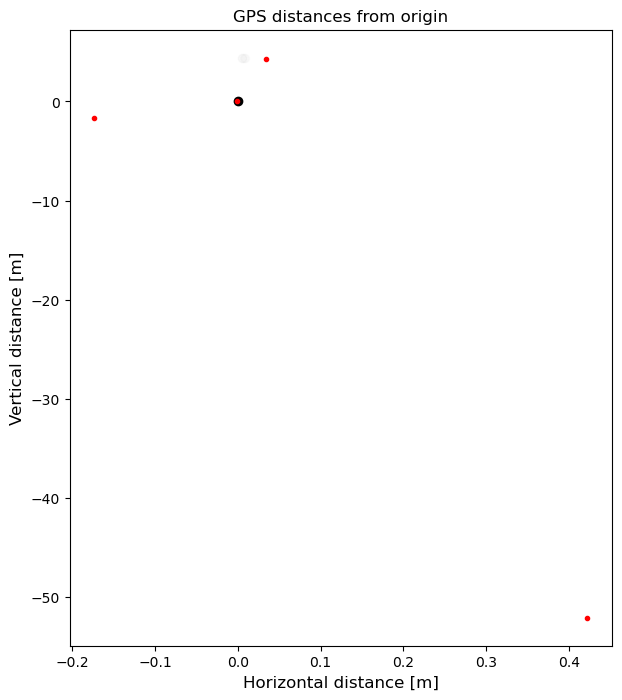

In [33]:
local = np.array(centers)

fig = plt.figure(figsize=(7, 8))
for k in range(0, len(sensors)):
    position = pos[k]
    plt.plot(position[0], position[1], "k.", markersize = 12, alpha = 0.01)
plt.plot(0, 0, "k.", markersize = 12, alpha = 1)
plt.plot(local[:,0], local[:,1], "r.", markersize = 6, alpha = 1)
plt.xlabel("Horizontal distance [m]", size = 12)
plt.ylabel("Vertical distance [m]", size = 12)
# plt.xlim(-25, 25)
#plt.ylim(-100, 15)
plt.title("GPS distances from origin", size = 12)
# plt.gca().set_aspect(1)

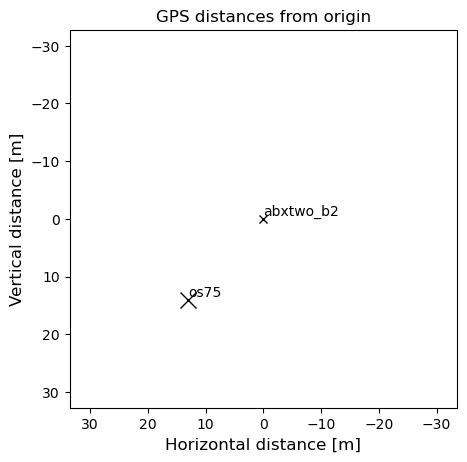

In [187]:
xmax = np.nanmax(centers[:,0])
ymax = np.nanmax(centers[:,1])
xmin = np.nanmax(centers[:,0])
ymin = np.nanmax(centers[:,1])

# --------------------------------------------------------------------------------
# plot the centerpoints.

fig = plt.figure(figsize=(5, 5))
plt.plot(centers[:,0], centers[:,1], "kx", markersize = 6, alpha = 1)
plt.plot(0, 0, "kx", markersize = 6, alpha = 1)
plt.annotate(pos_inst, (0+0.01, 0-0.5), size = 10)
for i in range(0, len(gps)):
    plt.annotate(gps[i], (centers[i,0]+0.01, centers[i, 1]-0.5), size = 10)
for sonar in proc_file['xducer_dx']:
    x = proc_file['xducer_dx'][sonar]
    y = proc_file['xducer_dy'][sonar]
    plt.plot(x, y, "kx", markersize = 12, alpha = 1)
    plt.annotate(sonar, (x+0.01, y-0.5), size = 10)
plt.xlabel("Horizontal distance [m]", size = 12)
plt.ylabel("Vertical distance [m]", size = 12)
plt.title("GPS distances from origin", size = 12)
plt.xlim(-xmax - 5, xmax + 5)
plt.ylim(-ymin - 5, ymax + 5)
plt.gca().set_aspect(1)
plt.show()

In [51]:
diff = abs(sup - inf)
